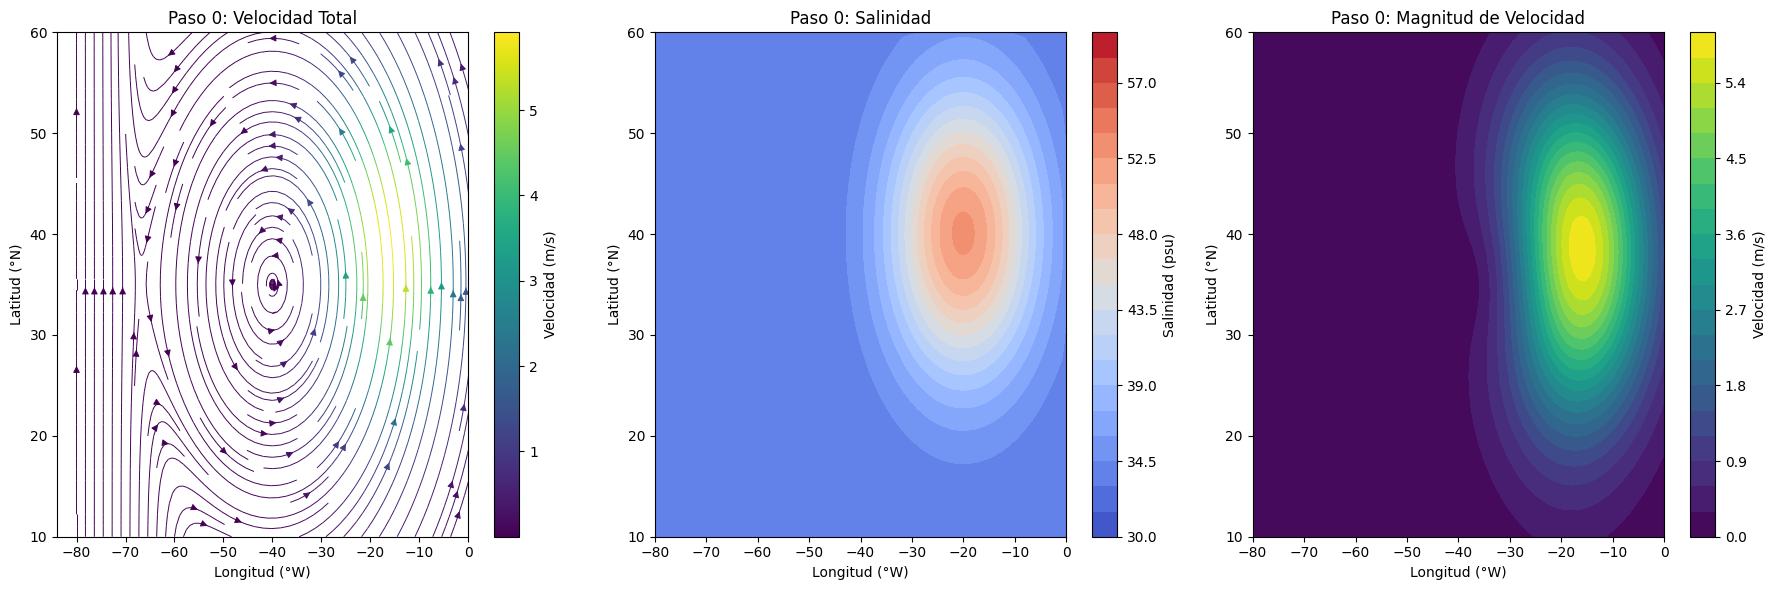

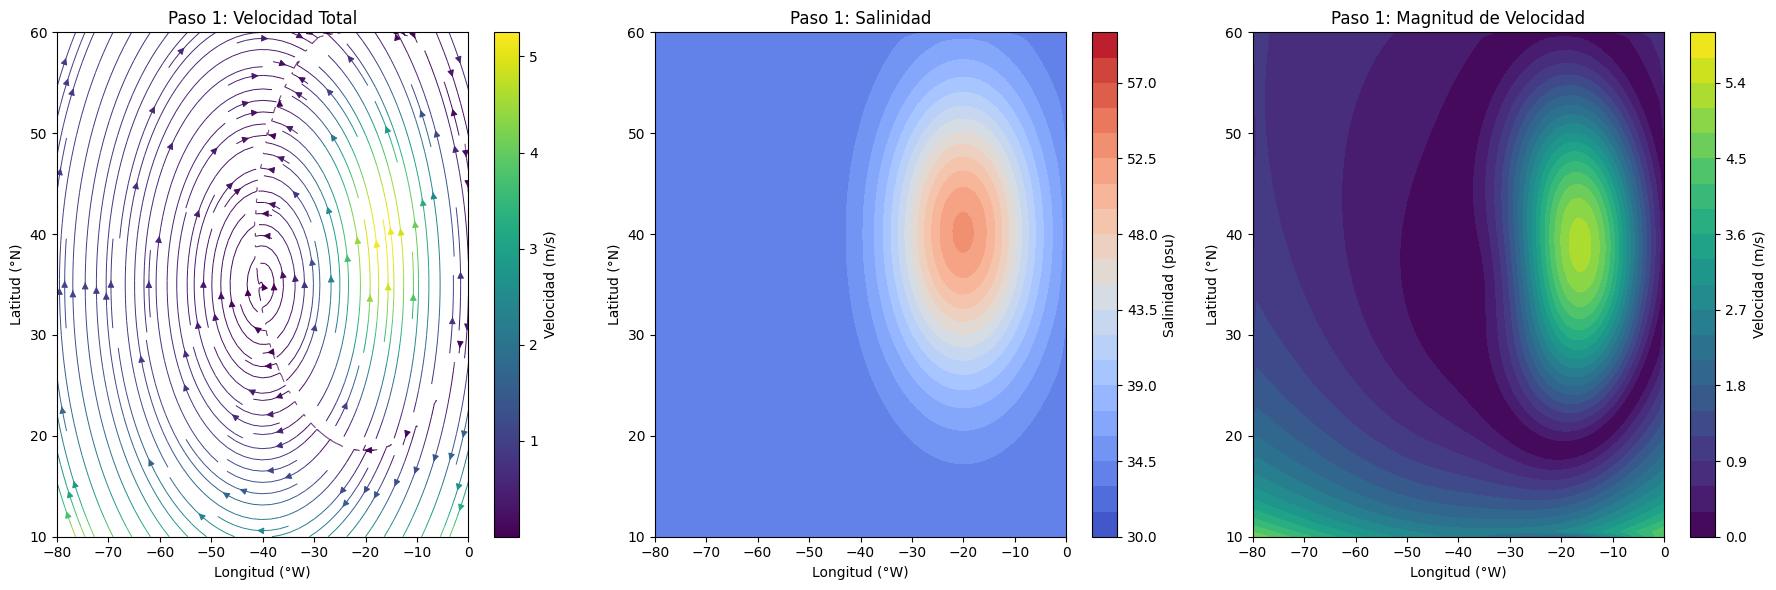

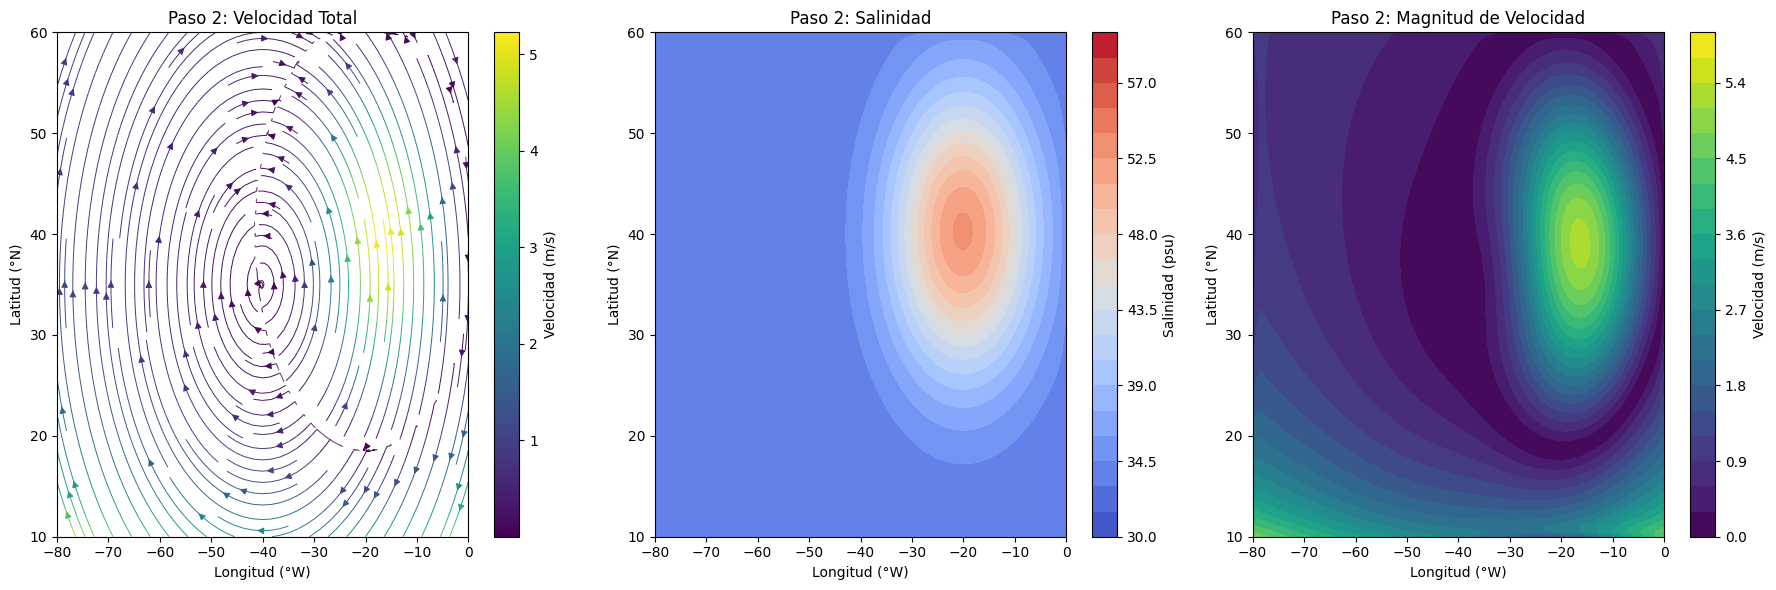

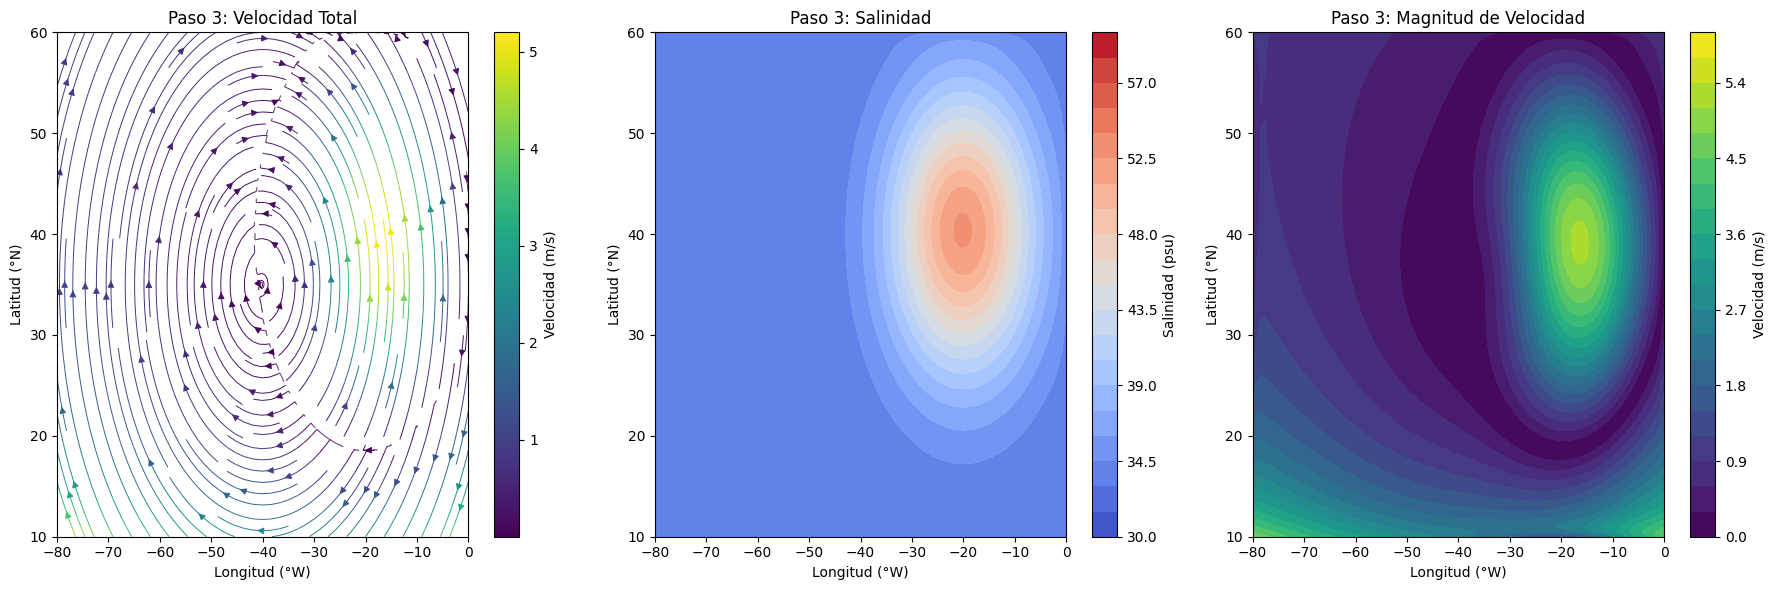

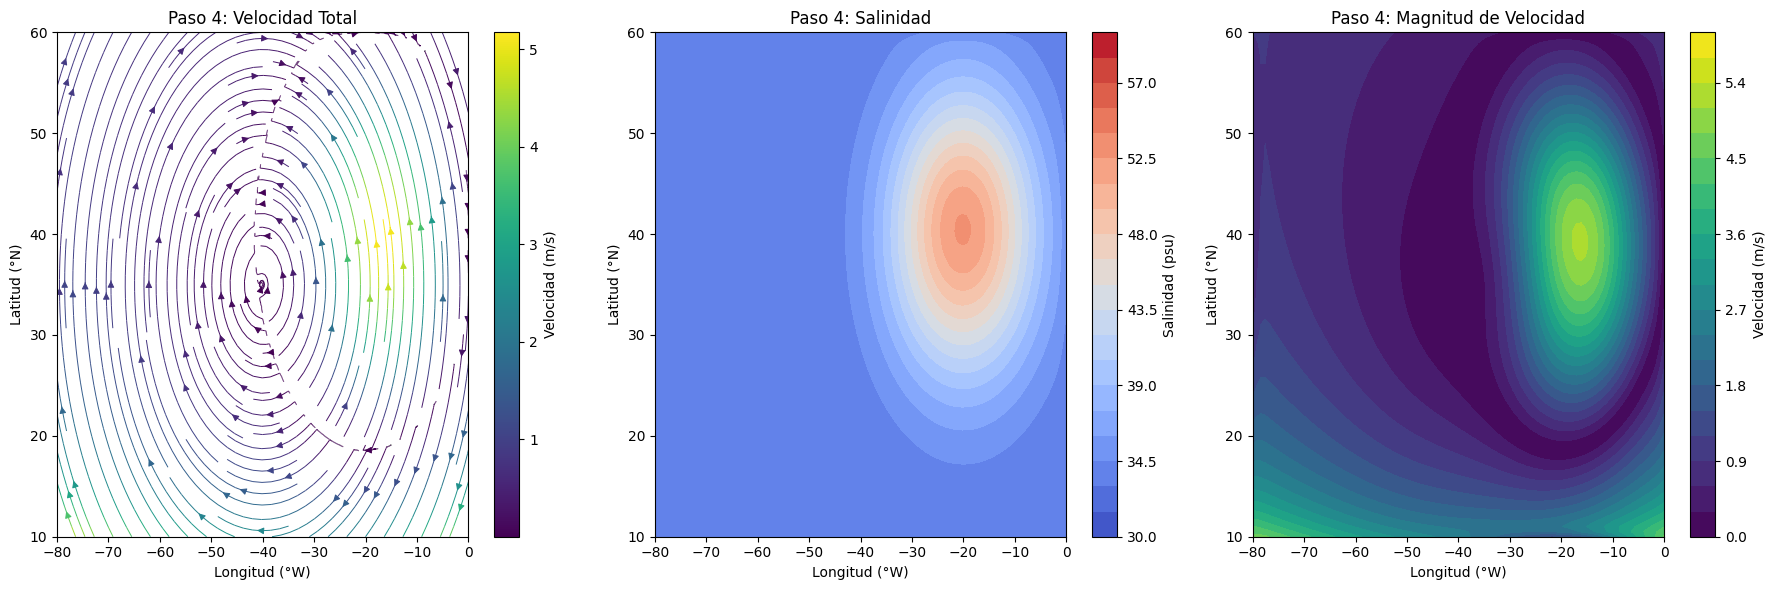

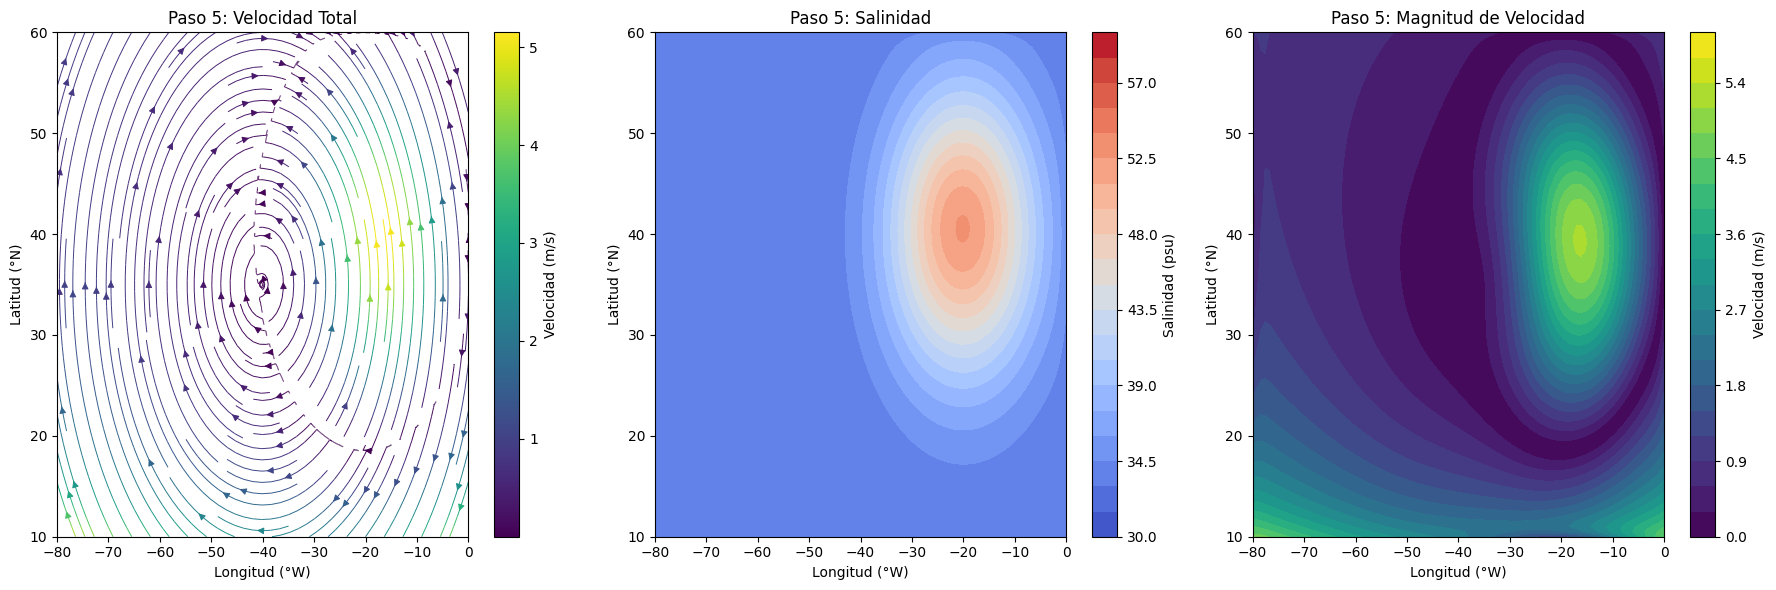

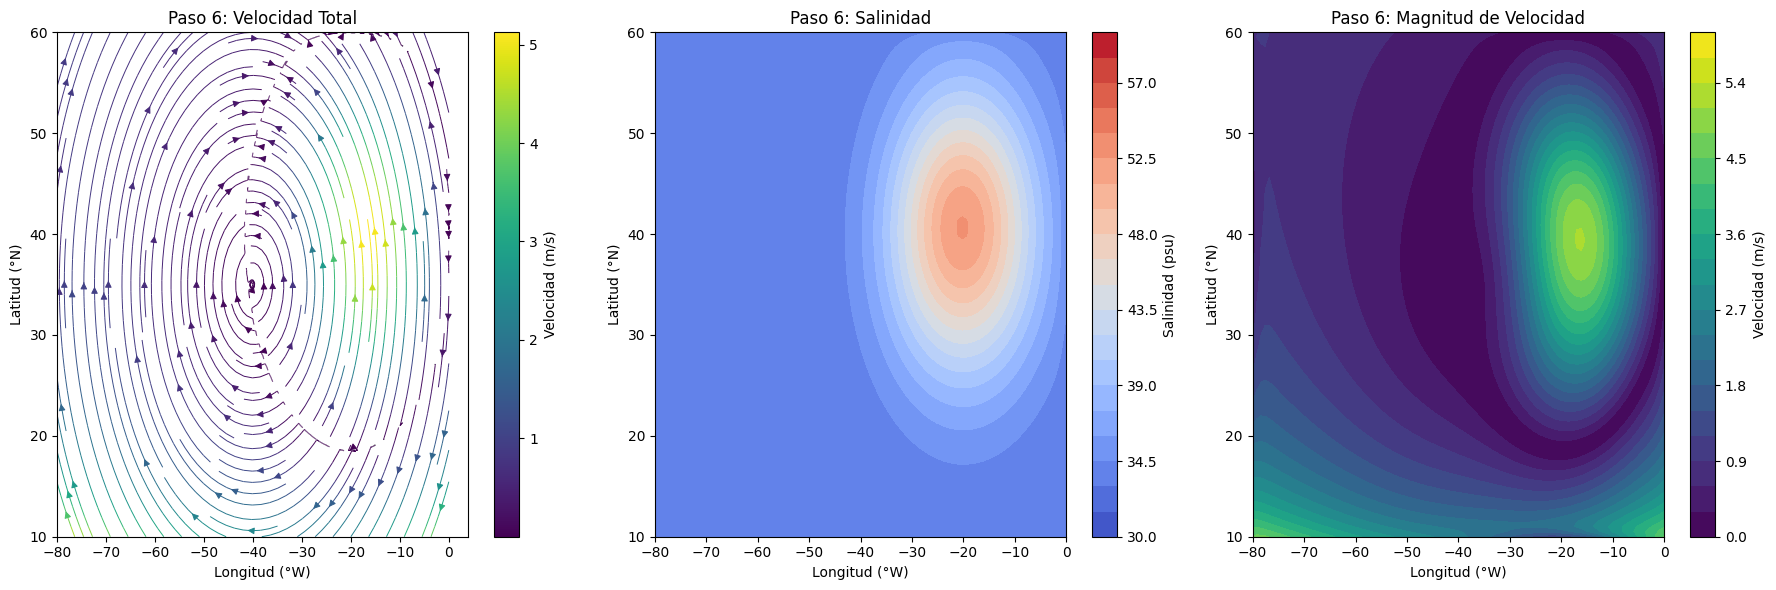

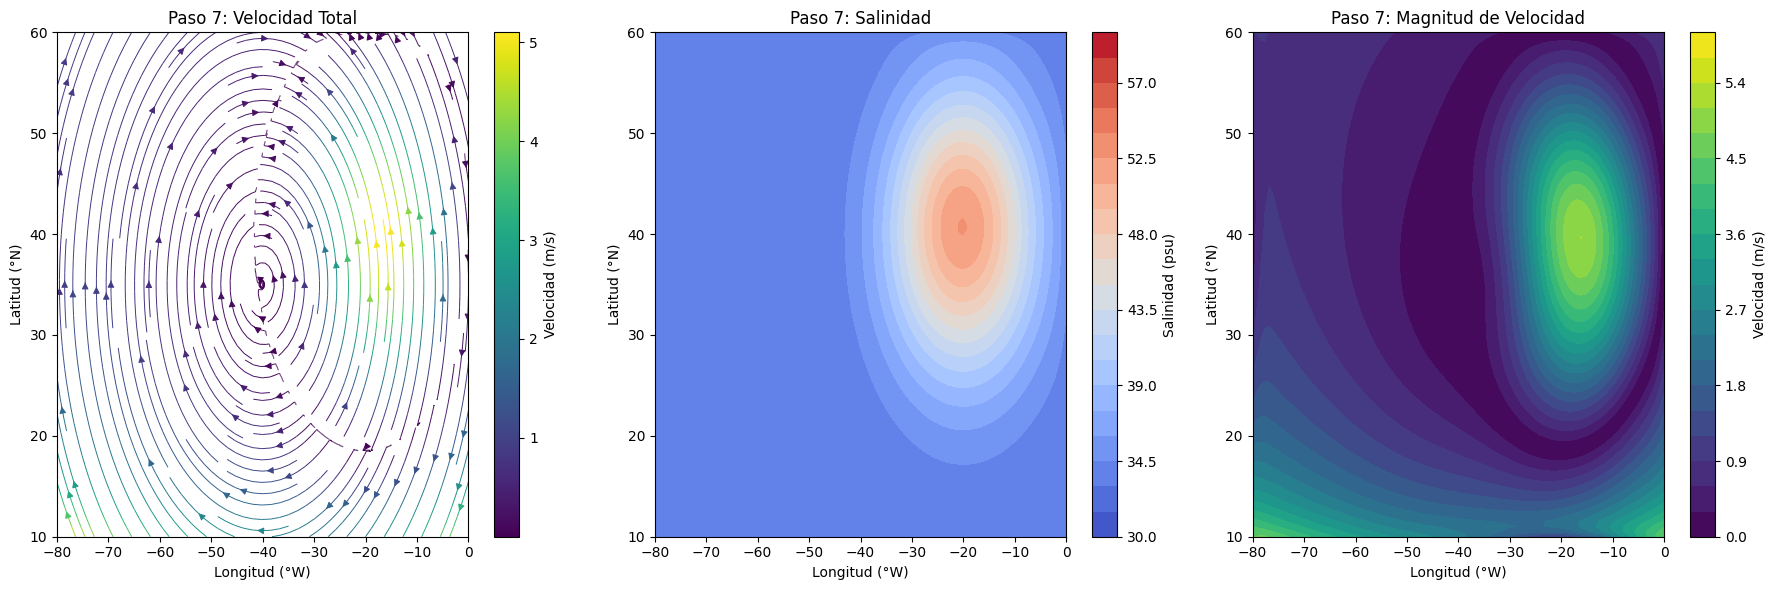

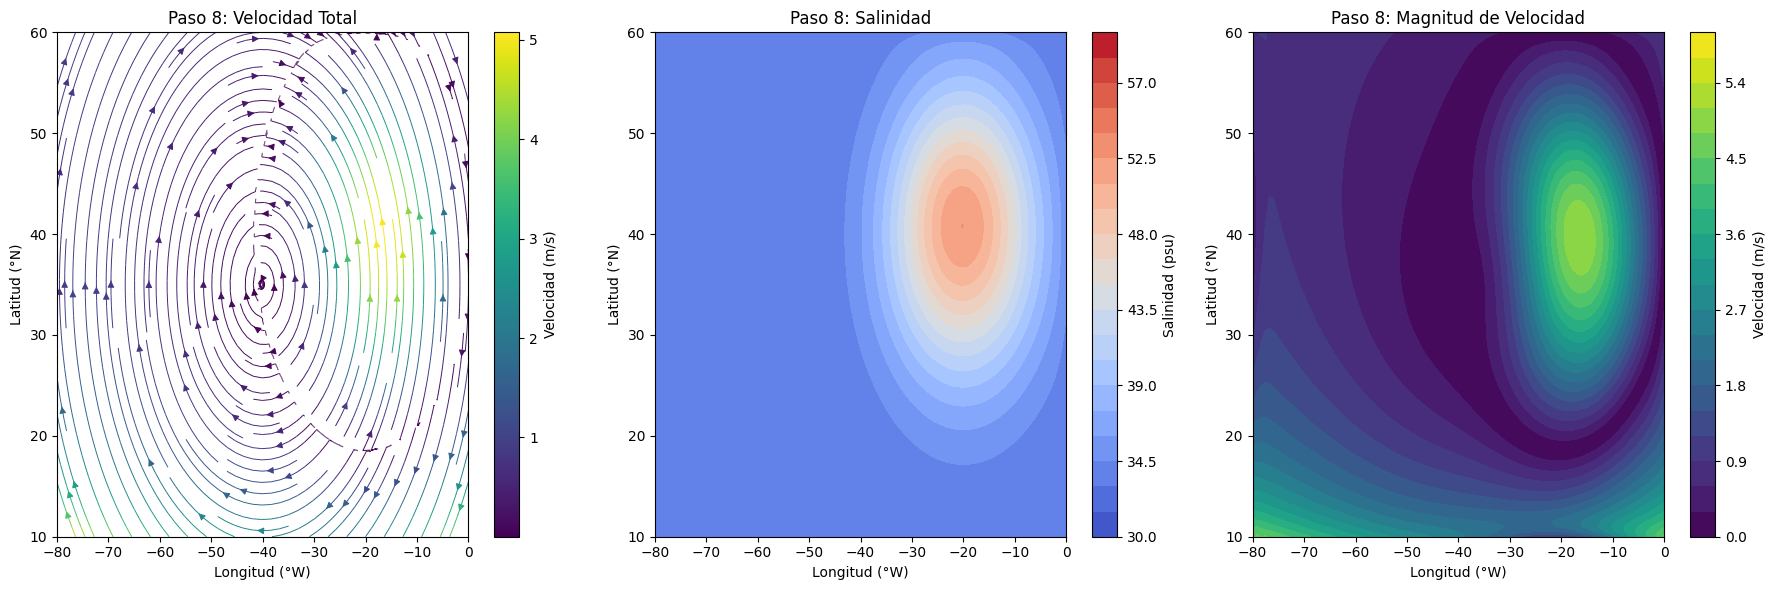

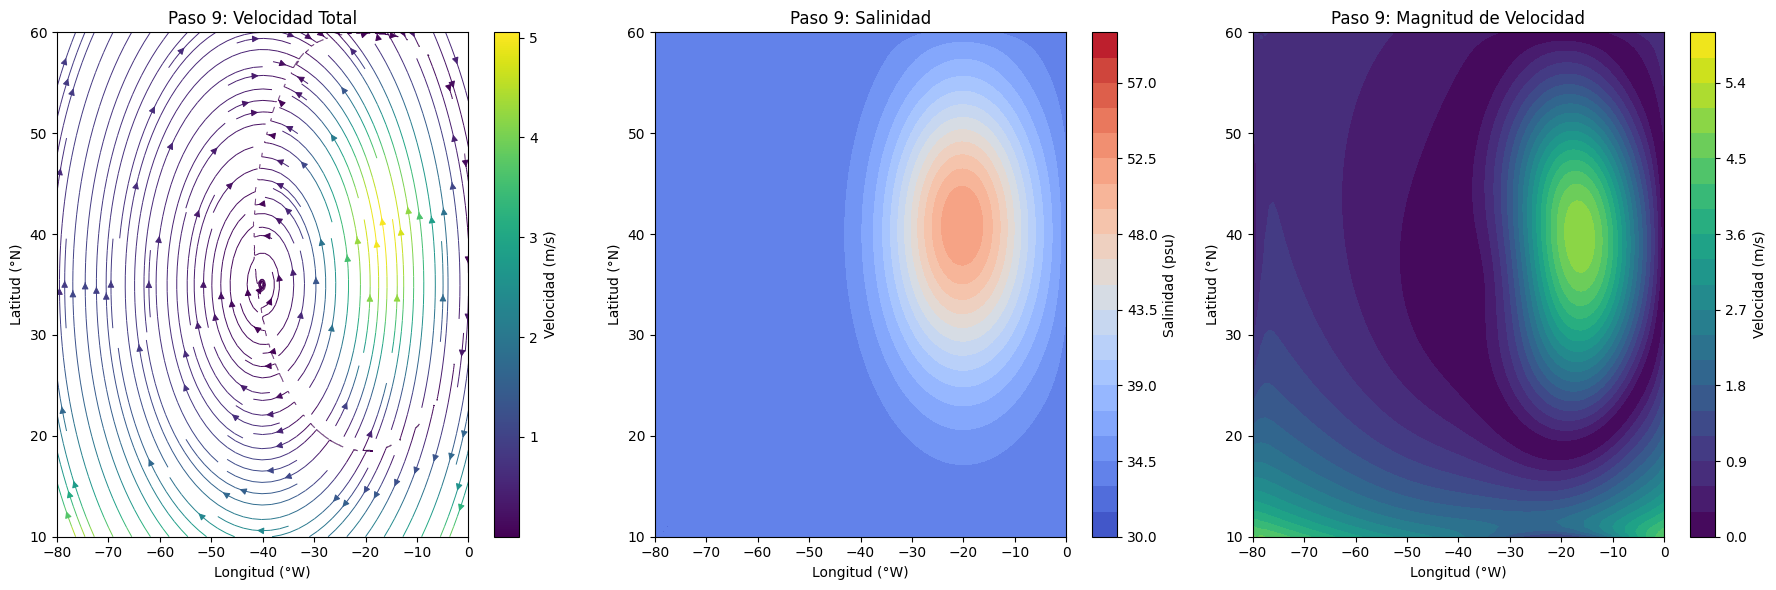

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
rho = 1025
Omega = 7.2921e-5
P0 = 1e3
g = 9.81 
lat_scale = 35
lon_scale = 40
model = "linear"
profundidad = 10000 
latitudes = np.linspace(10, 60, 100)
longitudes = np.linspace(-80, 0, 100)
Longitudes, Latitudes = np.meshgrid(longitudes, latitudes)

def calculate_pressure_gradient(Longitudes, Latitudes, P0, model, lat_scale=40, lon_scale=20):
    if model == "exponential":
        grad_P_y = -P0 * np.exp(-(Latitudes - lat_scale) / lat_scale)
        grad_P_x = P0 * np.exp(-(Longitudes + lon_scale) / lon_scale)
    elif model == "linear":
        delta_rho = density - rho
        P_prime = delta_rho 
        grad_P_y = -P_prime*P0 * (Latitudes - lat_scale) / lat_scale
        grad_P_x = (Longitudes + lon_scale) / lon_scale * P0 *P_prime
    elif model == "sinusoidal":
        grad_P_y = -P0 * np.sin(np.deg2rad(Latitudes / lat_scale))
        grad_P_x = P0 * np.cos(np.deg2rad(Longitudes / lon_scale))
    else:
        raise ValueError(f"Modelo '{model}' no reconocido.")
    return grad_P_x, grad_P_y


salinity = 33 * np.ones_like(Longitudes)
density = rho * np.ones_like(Longitudes)
temperature = 15 * np.ones_like(Longitudes)

# Perturbación 
x0, y0 = -20, 40
sigma = 10
salinity_perturbation = 20 * np.exp(-((Longitudes - x0)**2 + (Latitudes - y0)**2) / (2 * sigma**2))
salinity += salinity_perturbation

rho_s = 0.5
density += rho_s * (salinity - 33)

# Coriolis
f = 2 * Omega * np.sin(np.deg2rad(Latitudes))

# Viento
Cd = 1.2e-3
U = -10 * np.ones_like(Longitudes)
V = np.zeros_like(Longitudes)
tau_x = Cd * U**2 * np.sign(U)
tau_y = Cd * V**2 * np.sign(V)

# Espaciamiento
dx = longitudes[1] - longitudes[0]
dy = latitudes[1] - latitudes[0]

# Simulación
steps = 210
for step in range(steps):
 if step % 10 == 0:

    # Transporte de Ekman
    Q_x_ekman = tau_y / (f * density)
    Q_y_ekman = -tau_x / (f * density)

    # Gradiente de presión
    grad_P_x, grad_P_y = calculate_pressure_gradient(Longitudes, Latitudes, P0, model, lat_scale, lon_scale)
    Q_x_pressure = grad_P_y / (density * f)
    Q_y_pressure = grad_P_x / (density * f)

    # Transporte total
    Q_x_total = Q_x_ekman + Q_x_pressure
    Q_y_total = Q_y_ekman + Q_y_pressure

    # Velocidades
    V_x_total = Q_x_total / profundidad
    V_y_total = Q_y_total / profundidad

    # Paso de tiempo
    speed = np.sqrt(V_x_total**2 + V_y_total**2)
    dt = 0.2 * min(dx, dy) / (np.max(speed) + 1e-8)

    # Difusión
    D = 10

    # Advección
    salinity_x = (salinity - np.roll(salinity, 1, axis=1)) / dx
    salinity_y = (salinity - np.roll(salinity, 1, axis=0)) / dy
    advection = -(V_x_total * salinity_x + V_y_total * salinity_y)

    # Difusión de salinidad
    laplacian_salinity = (np.roll(salinity, 1, axis=0) + np.roll(salinity, -1, axis=0) +
                          np.roll(salinity, 1, axis=1) + np.roll(salinity, -1, axis=1) -
                          4 * salinity) / dx**2
    diffusion = D * laplacian_salinity

    # Actualizar salinidad
    salinity += dt * (advection + diffusion)

    # Actualizar densidad
    density = rho + rho_s * (salinity - 35)

    # Visualización
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.streamplot(Longitudes, Latitudes, V_x_total, V_y_total, color=speed,
                   cmap="viridis", density=1.5, linewidth=0.7, arrowsize=1)
    plt.colorbar(label="Velocidad (m/s)")
    plt.title(f"Paso {step}: Velocidad Total")
    plt.xlabel("Longitud (°W)")
    plt.ylabel("Latitud (°N)")

    # Subplot 2: Salinidad
    plt.subplot(1, 3, 2)
    sal_plot = plt.contourf(Longitudes, Latitudes, salinity, levels=np.linspace(30, 60, 21), cmap="coolwarm")
    plt.colorbar(sal_plot, label="Salinidad (psu)")
    plt.title(f"Paso {step}: Salinidad")
    plt.xlabel("Longitud (°W)")
    plt.ylabel("Latitud (°N)")

    # Subplot 3: Magnitud de velocidad
    plt.subplot(1, 3, 3)
    plt.contourf(Longitudes, Latitudes, speed, levels=np.linspace(0, 6, 21), cmap="viridis")
    plt.colorbar(label="Velocidad (m/s)")
    plt.title(f"Paso {step}: Magnitud de Velocidad")
    plt.xlabel("Longitud (°W)")
    plt.ylabel("Latitud (°N)")

    plt.tight_layout()
    plt.show()

    if step == 1:
            
            centro_lon = -40
            centro_lat = 35
            deg2m = 111000 
    
            r_i = np.sqrt((Longitudes - centro_lon)**2 + (Latitudes - centro_lat)**2) * deg2m
            l_i = 2 * np.pi * r_i
            velocidad_magnitud = np.sqrt(V_x_total**2 + V_y_total**2)
            P_i = velocidad_magnitud * l_i

            np.save("C:\\Users\\Ana\\Desktop\\Python TFG\\pasovsal_3.npy", P_i)

    if step == 200:
            
            centro_lon = -40
            centro_lat = 35
            deg2m = 111000 
    
            r_i = np.sqrt((Longitudes - centro_lon)**2 + (Latitudes - centro_lat)**2) * deg2m
            l_i = 2 * np.pi * r_i
            velocidad_magnitud = np.sqrt(V_x_total**2 + V_y_total**2)
            P_i = velocidad_magnitud * l_i

            np.save("C:\\Users\\Ana\\Desktop\\Python TFG\\pasovsal_25.npy", P_i)
